<a href="https://colab.research.google.com/github/Prakhar-Gupta-03/CV_Assignments/blob/main/A1/CV_A1_Q2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install wandb onnx -Uq

In [ ]:
import wandb
#WandB Login
wandb.login()

True

In [ ]:
model_config = dict(
    epochs=10,
    classes=10,
    kernels=[3, 3, 3],
    features=[32, 64, 128],
    batch_size=16,
    optimizer="Adam",
    learning_rate=0.001,
    dataset="Russian WildLife Dataset",
    architecture="ConvNet")

###Importing libraries

In [ ]:
import os
import torch
import pandas as pd
import numpy as np
from skimage import io, transform
from PIL import Image as im
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import utils
from torchvision.transforms import v2 as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from tqdm.auto import tqdm

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [82]:
# mounting the Google Drive
from google.colab import drive
drive.mount('/content/drive')
os.chdir('/content')
!unzip "content/drive/MyDrive/Cropped_final_downloaded_ver.zip" -d "content/Data/Cropped_final"
os.chdir('/content/Data/Cropped_final')
!pwd

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
unzip:  cannot find or open content/drive/MyDrive/Cropped_final_downloaded_ver.zip, content/drive/MyDrive/Cropped_final_downloaded_ver.zip.zip or content/drive/MyDrive/Cropped_final_downloaded_ver.zip.ZIP.


FileNotFoundError: [Errno 2] No such file or directory: '/content/Data/Cropped_final'

In [85]:
os.chdir('/content')

In [86]:
!pwd

/content


In [87]:
!unzip "content/drive/MyDrive/Cropped_final_downloaded_ver.zip" -d "content/Data/Cropped_final"

unzip:  cannot find or open content/drive/MyDrive/Cropped_final_downloaded_ver.zip, content/drive/MyDrive/Cropped_final_downloaded_ver.zip.zip or content/drive/MyDrive/Cropped_final_downloaded_ver.zip.ZIP.


###Dataset Class

In [76]:
class RussianWildLifeDataset(Dataset):
  def __init__(self, root_dir, transform):
    self.transform = transform
    self.root_dir = root_dir
    self.classes = os.listdir(self.root_dir)
    self.classes.sort()
    self.class_index_mapping = dict(zip(range(len(self.classes)), self.classes))
    self.__load_data__()

  def __load_data__(self):
    self.images_filenames = []
    self.labels = []
    for i in range(len(self.class_index_mapping)):
      class_path = os.path.join(self.root_dir, self.class_index_mapping[i])
      for image in os.listdir(class_path):
        self.images_filenames.append(os.path.join(class_path, image))
        self.labels.append(i)

  def get_class_name(self, label):
    return self.class_index_mapping[label]

  def __len__(self):
    return len(self.labels)

  def __getitem__(self, idx):
    image = im.open(self.images_filenames[idx])
    label = self.labels[idx]
    if (self.transform):
      image = self.transform(image)
    sample = {'image':image, 'label':label}
    return sample

###Transformations

In [77]:
composed_transform = transforms.Compose([
    transforms.Resize([224, 224]),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

###Dataset and DataLoaders

In [78]:
dataset = RussianWildLifeDataset("/content/Cropped_final", composed_transform)
train_dataset, val_dataset, test_dataset = random_split(dataset, [0.7, 0.1, 0.2])
train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=0)
val_dataloader = DataLoader(val_dataset, shuffle=False)
test_dataloader = DataLoader(test_dataset, shuffle=False)

###Visualizing Training Data

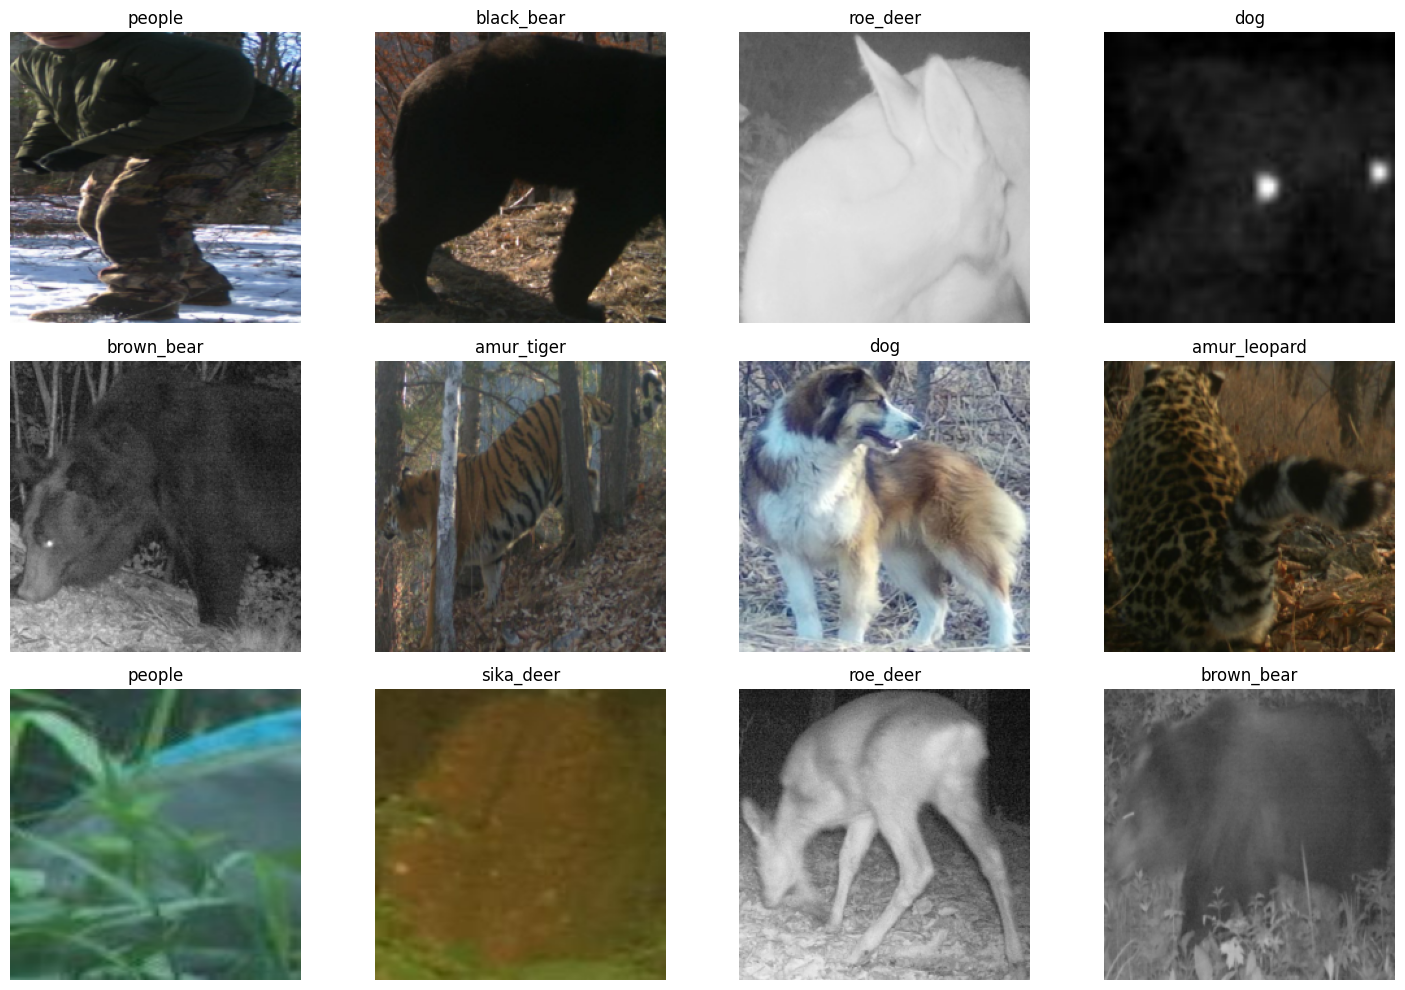

In [79]:
num_rows = 3
num_cols = 4
fig, axs = plt.subplots(num_rows, num_cols, figsize=(15, 10))
for i in range(num_rows):
    for j in range(num_cols):
        idx = i * num_cols + j
        if idx >= len(train_dataset):
            break
        sample = train_dataset[idx]
        axs[i, j].set_title(f"{dataset.get_class_name(sample['label'])}")
        axs[i, j].axis('off')
        # Bringing the image to (0, 255) space, reducing the batch dimension, converting float to int and converting Tensor to PIL Image
        image = transforms.ToPILImage()((((sample['image']+1)/2) * 255).squeeze().to(torch.uint8))
        axs[i, j].imshow(image)
plt.tight_layout()
plt.show()

###Visualizing Validation Data


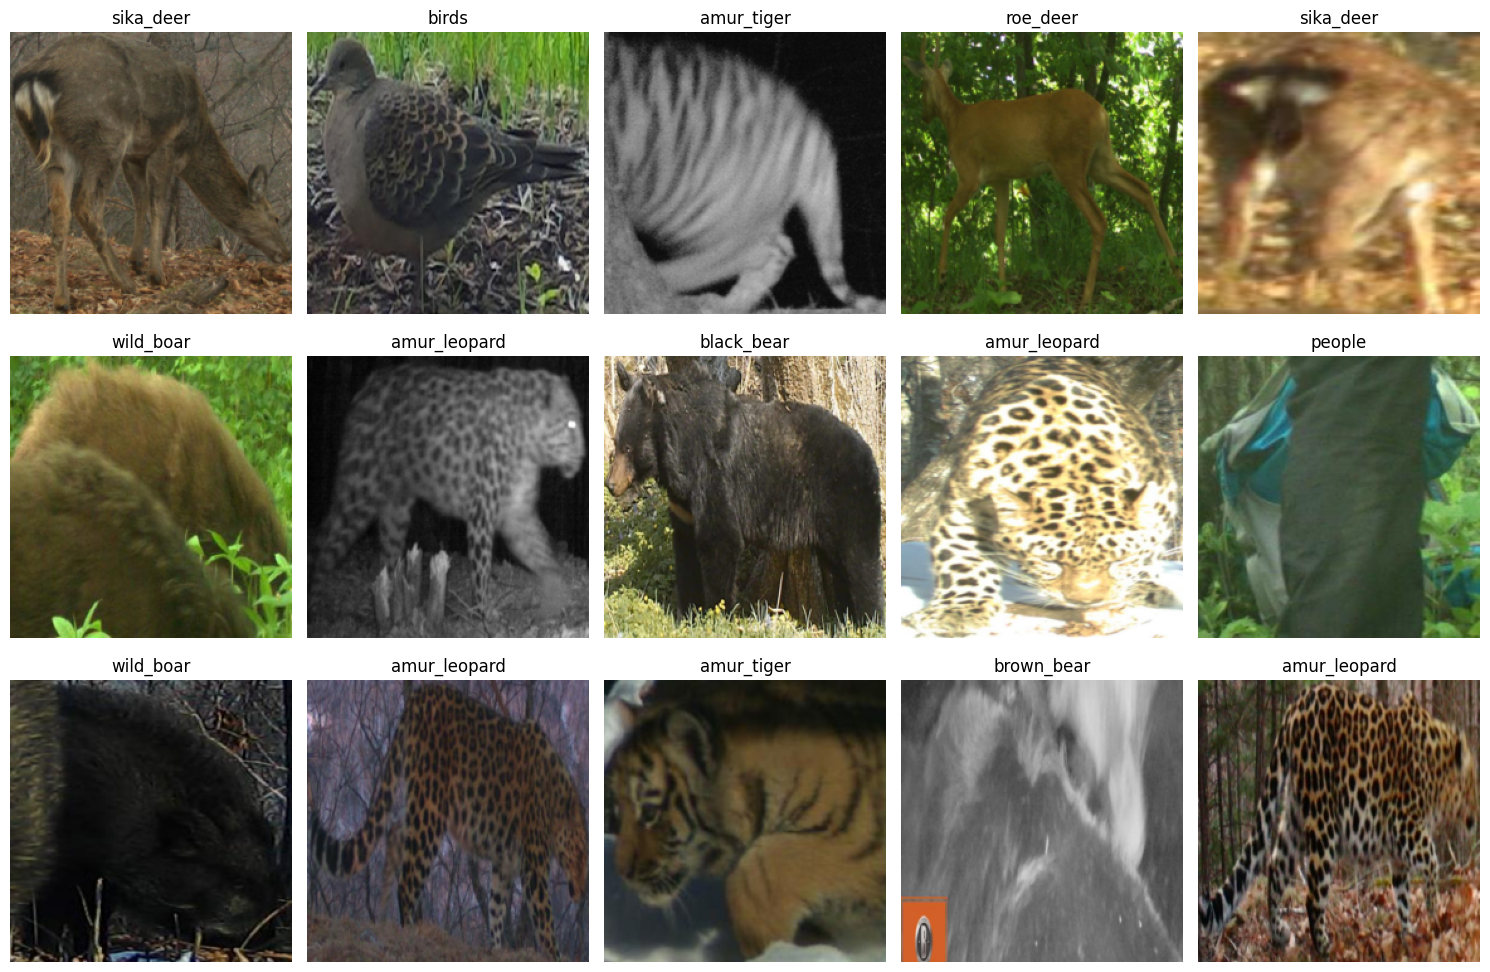

In [80]:
num_rows = 3
num_cols = 5
fig, axs = plt.subplots(num_rows, num_cols, figsize=(15, 10))
for i in range(num_rows):
    for j in range(num_cols):
        idx = i * num_cols + j
        if idx >= len(val_dataset):
            break
        sample = val_dataset[idx]
        axs[i, j].set_title(f"{dataset.get_class_name(sample['label'])}")
        axs[i, j].axis('off')
        # Bringing the image to (0, 255) space, reducing the batch dimension, converting float to int and converting Tensor to PIL Image
        image = transforms.ToPILImage()((((sample['image']+1)/2) * 255).squeeze().to(torch.uint8))
        axs[i, j].imshow(image)
plt.tight_layout()
plt.show()

In [ ]:
class ConvNet(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv_layer1 = nn.Sequential(
        # First Convolutional Layer
        nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=4, stride=4)
    )
    self.conv_layer2 = nn.Sequential(
        # Second Convolutional Layer
        nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2)
    )
    self.conv_layer3 = nn.Sequential(
        # Third Convolutional Layer
        nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2)
    )
    self.fully_connected = nn.Sequential(
        nn.Linear(128*14*14, 10),
        nn.ReLU()
    )
    self.softmax = nn.Softmax(dim=1)

  def forward(self, x):
    x = self.conv_layer1(x)
    x = self.conv_layer2(x)
    x = self.conv_layer3(x)
    x = torch.flatten(x, 1)
    logits = self.fully_connected(x)
    return logits

  def softmax(self, x):
    x = self.softmax(x)
    return x

model = ConvNet()

<class 'PIL.JpegImagePlugin.JpegImageFile'>
torch.Size([1, 128, 14, 14])


In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
running_loss = 0.0
for epoch in range(model_config["epochs"]):
  for i, sample in enumerate(train_dataloader, 0):
    # fetch data
    input = sample['image']
    label = sample['label']
    # zero the gradients before backprop
    optimizer.zero_grad()
    # forward pass
    logits = model.forward(input)
    loss = loss_fn(logits, label)
    # backprop
    loss.backward()
    optimizer.step()
    # loss computations and logging
    minibatch_loss = loss.item()
    running_loss += minibatch_loss
    # logging all the minibatch loss values

    # logging after every 100 mini-batches
    if (i%100==0):
      # for every 100th mini-batch, computing training, val loss and accuracies, along with running loss logging
      running_loss /= 100.0
      # logging running_loss
      running_loss = 0.0
      # computing train loss, train accuracy, val loss, val accuracy
      with torch.no_grad():

      # logging train loss, train acc, val loss, val acc
# Use wandb to log the training and validation losses and accuracies.

# Look at the training and validation loss plots and comment whether the model is overfitting or not.Report the Accuracy and F1-Score on the test set.


# Also, log the confusion matrix using wandb.For each class in the test set, visualize any 3 images that were misclassified along with the predicted class label.
# Analyze why the model could possibly be failing in these cases. Is this due to the fact that the image does not contain the ground truth class or it looks more
# similar to the predicted class or something else? Can you think of any workaround for such samples?